# Ensemble learning on functional connectivity

This notebook demonstrates how to use the FUCONE approach in Brain-Computer Interfaces (BCI). The objective is to combine several feature spaces from functional connectivity estimator in order to improve the robustness of brain activity prediction.

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from mne import set_log_level as mne_log

from moabb.datasets import Cho2017
from moabb.paradigms import LeftRightImagery
from moabb.utils import set_log_level as moabb_log

from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import FgMDM

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning

from warnings import filterwarnings

from fc_pipeline_classif import (
    EnsureSPD,
    FunctionalTransformer,
    GetData,
    Epochs2cov,
    get_results,
)

Disable log messages:

In [2]:
mne_log('CRITICAL')
moabb_log('CRITICAL')
filterwarnings(action='ignore', category=ConvergenceWarning)
filterwarnings(action='ignore', category=UserWarning)

We use the first subject from Cho et al (2017) dataset. With MOABB, it is easy to download and preprocess EEG from open data available on the web. We compare our FUCONE approach with state of the art algorithms, using scikit-learn pipelines to ease the machine learning processing

In [3]:
dataset = Cho2017()
spectral_met = ["cov", "imcoh", "instantaneous"]
fmin, fmax = 8, 35
nchan = 64

## state of the art pipelines
param_svm = {"kernel": ("linear", "rbf"), "C": [0.1, 1, 10]}
step_csp = [("cov", Epochs2cov()), ("csp", CSP(nfilter=6)), ("optsvm", GridSearchCV(SVC(), param_svm, cv=3))]
step_mdm = [("cov", Epochs2cov()), ("fgmdm", FgMDM(metric="riemann", tsupdate=False))]

## Covariance-based Riemannian geometry
param_lr = {
    "penalty": "elasticnet",
    "l1_ratio": 0.15,
    "intercept_scaling": 1000.0,
    "solver": "saga",
}

## Functional connectivity-based Riemannian geometry
ft_param = {"delta": 1, "ratio": 0.5, "fmin": fmin, "fmax": fmax}
step_fc = [("spd", EnsureSPD()),
           ("tg", TangentSpace(metric="riemann")),
           ("LogistReg", LogisticRegression(**param_lr))]

This code could work for several subjects, we restrict to one for this example. In order to use scikit-learn pipeline on MNE epochs, we wrote scikit estimators like `GetData` and `FunctionalTransformer`. GetData return the epoch associated ith a trial number. FunctionalTransformer takes an epoch to estimate functional connectivity metric (like coherence, PLV, PLI, ...). The FUCONE pipeline relies on ensemble learning (here stacking classifier) to combine classifier acting on different functional connectivity features. 

To avoid redundant computation, we extract the accuracy scores of functional connectivity pipelines from the ensemble pipeline. 

In [15]:
dataset_res = list()
subj_cho = [50]
for subject in subj_cho:
    ppl_fc, ppl_ens, ppl_baseline = {}, {}, {}
    paradigm = LeftRightImagery(fmin=fmin, fmax=fmax)
    gd = GetData(paradigm, dataset, subject)

    # baseline pipeline
    ppl_baseline["CSP+optSVM"] = Pipeline(steps=[("gd", gd)] + step_csp)
    ppl_baseline["FgMDM"] = Pipeline(steps=[("gd", gd)] + step_mdm)

    # functionnal connectivity pipeline
    for sm in spectral_met:
        ft = FunctionalTransformer(**ft_param, method=sm)
        pname = sm + "+elasticnet"
        ppl_fc[pname] = Pipeline(steps=[("gd", gd), ("ft", ft)] + step_fc)

    # ensemble pipeline
    fc_estim = [(n, ppl_fc[n]) for n in ppl_fc]
    cvkf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    lr = LogisticRegression(**param_lr)
    ppl_ens["ensemble"] = StackingClassifier(
        estimators=fc_estim,
        cv=cvkf,
        n_jobs=1,
        final_estimator=lr,
        stack_method="predict_proba",
    )
    all_ppl = {**ppl_baseline, **ppl_ens}

    # Compute results
    dataset_res += get_results(paradigm, dataset, subject, nchan, fmin, fmax, all_ppl)
dataset_res = pd.DataFrame(dataset_res)

pipelines: 100%|██████████| 3/3 [02:32<00:00, 50.74s/it]

pipelines: 100%|██████████| 3/3 [02:33<00:00, 51.23s/it]

pipelines: 100%|██████████| 3/3 [02:31<00:00, 50.47s/it]

pipelines: 100%|██████████| 3/3 [02:31<00:00, 50.37s/it]

session: 100%|██████████| 1/1 [12:38<00:00, 758.93s/it]


In [16]:
dataset_res

,score,kappa,accuracy,pipeline,n_dr,thres,subject,session,channels,n_sessions,FreqBand,dataset,fmin,fmax,samples,time,split
0,0.800,0.60,0.800,CSP+optSVM,64,0,50,session_0,64,1,defaultBand,Cho2017,8,35,200,0.0,0
1,0.950,0.90,0.950,FgMDM,64,0,50,session_0,64,1,defaultBand,Cho2017,8,35,200,0.0,0
2,0.950,0.90,0.950,ensemble,64,0,50,session_0,64,1,defaultBand,Cho2017,8,35,200,0.0,0
3,0.925,0.85,0.925,cov+elasticnet,64,0,50,session_0,64,1,defaultBand,Cho2017,8,35,200,0.0,0
4,0.550,0.10,0.550,imcoh+elasticnet,64,0,50,session_0,64,1,defaultBand,Cho2017,8,35,200,0.0,0
5,0.900,0.80,0.900,instantaneous+elasticnet,64,0,50,session_0,64,1,defaultBand,Cho2017,8,35,200,0.0,0
6,0.850,0.70,0.850,CSP+optSVM,64,0,50,session_0,64,1,defaultBand,Cho2017,8,35,200,0.0,1
7,0.700,0.40,0.700,FgMDM,64,0,50,session_0,64,1,defaultBand,Cho2017,8,35,200,0.0,1
8,0.975,0.95,0.975,ensemble,64,0,50,session_0,64,1,defaultBand,Cho2017,8,35,200,0.0,1
9,0.975,0.95,0.975,cov+elasticnet,64,0,50,session_0,64,1,defaultBand,Cho2017,8,35,200,0.0,1


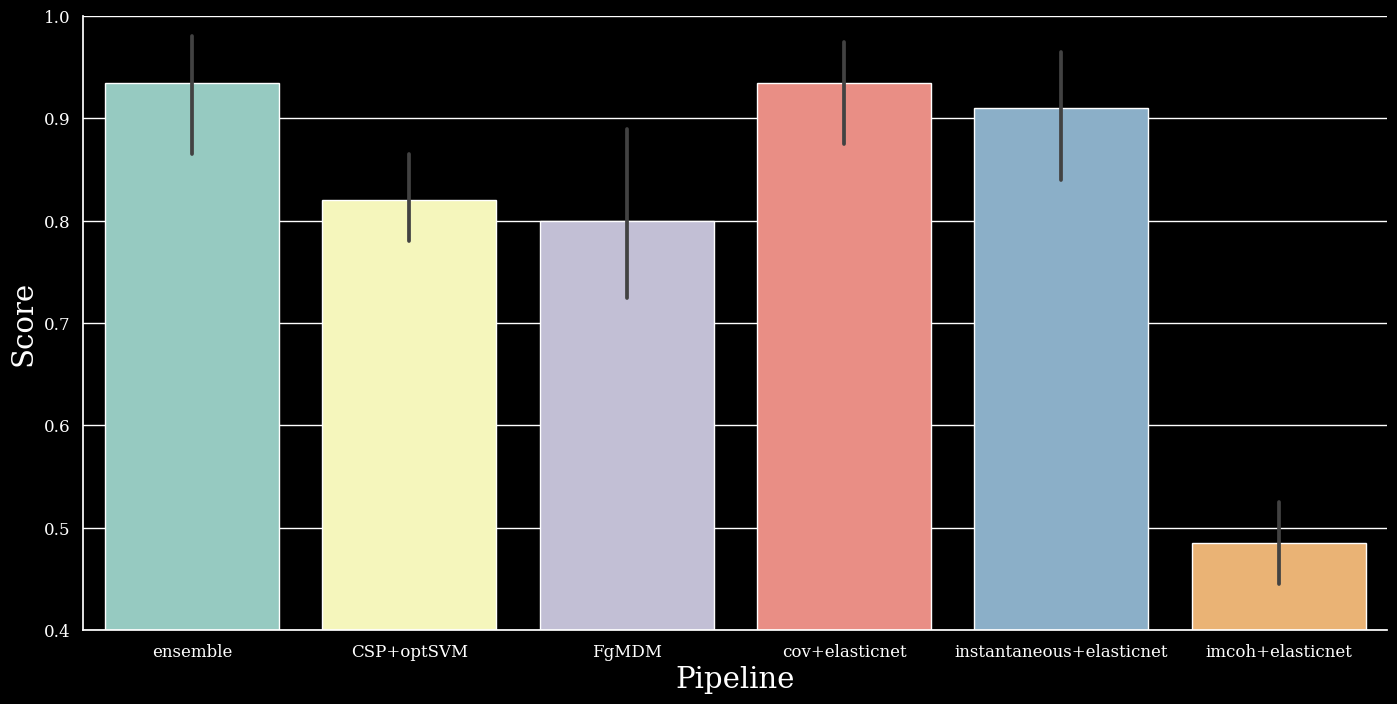

In [23]:
list_fc_ens = [
    "ensemble",
    "CSP+optSVM",
    "FgMDM",
    "cov+elasticnet",
    "instantaneous+elasticnet",
    "imcoh+elasticnet"
]

# plots FC vs ens
plt.close("all")
plt.style.use("dark_background")
g = sns.catplot(
    data=dataset_res,
    x="pipeline",
    y="score",
    kind="bar",
    #saturation=0.5,
    order=list_fc_ens,
    height=7,
    aspect=2, #1.5
)
plt.ylim((0.4, 1))
plt.xticks(range(len(dataset_res["pipeline"].unique())),
           fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Pipeline", fontsize=21)
plt.ylabel("Score", fontsize=21)
plt.show()